# Bayesian parameter inference from single-molecule mRNA FISH data.

(c) 2019 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

---

In [1]:
import pickle

# Our numerical workhorses
import numpy as np
import scipy.optimize
import scipy.special
import scipy.integrate
import mpmath
import pandas as pd
import emcee

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages 
import corner

# Seaborn, useful for graphics
import seaborn as sns

# Import the project utils
import sys
sys.path.insert(0, '../../')
import ccutils

# This enables high resolution graphics inline
%config InlineBackend.figure_format = 'retina'

figdir = '../../fig/chemical_master_mRNA_FISH/'
tmpdir = '../../tmp/'

In [2]:
# Set PBoC plotting style
ccutils.viz.set_plotting_style()
# Increase dpi
mpl.rcParams['figure.dpi'] = 110

### $\LaTeX$ macros
$\newcommand{\kpon}{k^{(p)}_{\text{on}}}$
$\newcommand{\kpoff}{k^{(p)}_{\text{off}}}$
$\newcommand{\rm}{r _m}$
$\newcommand{\gm}{\gamma _m}$
$\newcommand{\mm}{\left\langle m \right\rangle}$
$\newcommand{\ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{\eP}{\Delta\varepsilon_p}$
$\newcommand{\foldchange}{\text{fold-change}}$

## Exploring the single-molecule mRNA FISH data from Jones et al. 2014.

In this notebook we will explore the use of the raw data from [Jones et al. 2014](http://science.sciencemag.org/content/346/6216/1533) on single molecule mRNA FISH data to make progress in determining parameters for the model.

First of all let's load the data.

In [3]:
# Read the data
df = pd.read_csv('../../data/mRNA_FISH/Jones_Brewster_2014.csv', index_col=0)

# Remove the different controls with no mRNA
df = df[(df.experiment != 'control') & 
        (df.experiment != 'Control') &
        (df.experiment != 'Ctrl')]
df.head()

,area_cells,date,experiment,mRNA_cell,num_intens_totals,spots_totals
0,402,20111220,UV5,27,4.544086,21
1,288,20111220,UV5,19,3.196886,14
2,358,20111220,UV5,25,4.249250,19
3,310,20111220,UV5,30,5.075867,22
4,300,20111220,UV5,31,5.361156,24


Now let's plot the raw data for the *lacUV5* promoter used in the project.

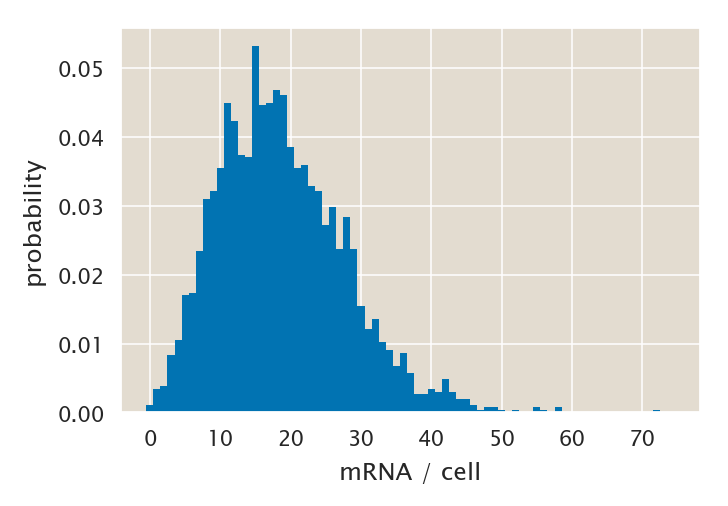

In [4]:
# Extract the lacUV5 data
dfUV5 = df[df.experiment == 'UV5']

# Plot the histogram of the data with bins of width 1
_ = plt.hist(dfUV5.mRNA_cell, bins=np.arange(0, dfUV5.mRNA_cell.max()),
             density=1, histtype='stepfilled', align='left', lw=0)

# Label the plot
plt.xlabel('mRNA / cell')
plt.ylabel('probability')
plt.tight_layout()
plt.savefig(figdir + 'lacUV5_smFISH_data.pdf', bbox_inches='tight')

## Two-state unregulated promoter model

Given the lack of agreement between the theory and the data at the protein level we will explore the possibility of using a two-state model for the unregulated promter where it transitions from an empty promoter to occupied by RNAP.

[Peccoud & Ycart](http://www.sciencedirect.com/science/article/pii/S0040580985710271) first derived the mRNA distribution for a two-state promoter from the chemical master equation. This distribution is given by

$$
\scriptstyle
P(m) = {\Gamma\left( {\kpon \over \gm} + m \right) \over
        \Gamma (m + 1) \Gamma\left( {\kpon + \kpoff \over \gm} + m \right)}
        {\Gamma\left( {\kpon + \kpoff \over \gm} \right) \over
         \Gamma\left( {\kpon \over \gm} \right) } 
         \left( {\rm \over \gm} \right)^m
         {}_1F_1 \left( {\kpon \over \gm} + m, {\kpoff + \kpon \over \gm} + m,
                       {-\rm \over \gm} \right),
\tag{1}
$$
where ${}_1F_1$ is the confluent hypergeometric function.

Let's define a function that computes the log probability.

In [5]:
# define a np.frompyfunc that allows us to evaluate the sympy.mp.math.hyp1f1
np_log_hyp= np.frompyfunc(lambda x, y, z: \
mpmath.ln(mpmath.hyp1f1(x, y, z, zeroprec=1000)), 3, 1)

def log_p_m_unreg(mRNA, kp_on, kp_off, gm, rm):
    '''
    Computes the log probability lnP(m) for an unregulated promoter, 
    i.e. the probability of having m mRNA.
    
    Parameters
    ----------
    mRNA : float.
        mRNA copy number at which evaluate the probability.        
    kp_on : float.
        rate of activation of the promoter in the chemical master equation
    kp_off : float.
        rate of deactivation of the promoter in the chemical master equation
    gm : float.
        1 / half-life time for the mRNA.
    rm : float.
        production rate of the mRNA
    
    Returns
    -------
    log probability lnP(m)
    '''
    # Convert the mRNA copy number to a  numpy array
    mRNA = np.array(mRNA)
    
    # Compute the probability
    lnp = scipy.special.gammaln(kp_on / gm + mRNA) \
    - scipy.special.gammaln(mRNA + 1) \
    - scipy.special.gammaln((kp_off + kp_on) / gm + mRNA) \
    + scipy.special.gammaln((kp_off + kp_on) / gm) \
    - scipy.special.gammaln(kp_on / gm) \
    + mRNA * np.log(rm / gm) \
    + np_log_hyp(kp_on / gm + mRNA,
            (kp_off + kp_on) / gm + mRNA, -rm / gm)
    
    return lnp.astype(float)

## Bayesian parameter inference

We know that the model is homogeneous in time. What that means is that changing the time scale by a constant is equivalent to dividing all rates by the same constant. Therefore we can only hope to determine the parameter value in units of one of the rate constants. Therefore we will define $\gm \equiv 1$ and the rest of the inferred constants will be in units of this degradation rate.

Given that we want to infer three parameters, $\kpon$, $\kpoff$ and $\rm$ we can write Bayes theorem as

$$
P(\mathbf{p} \mid D) = {P(D \mid \mathbf{p}) P(\mathbf{p})
\over P(D)},
\tag{2}
$$
where $\mathbf{p} = (\kpon, \kpoff, \rm)$, and $D$ is the data. 

For the likelihood $P(D \mid \mathbf{p})$ we will assume each datum is independent, i.e.

$$
P(D \mid \mathbf{p}) = \prod_{m \in D} P(m \mid \mathbf{p}),
\tag{3}
$$
where each probability of obtaining $m$ mRNAs $P(m \mid \mathbf{p})$ is given by the solution of the chemical master equation as defined previously. Given our null prior knowledge about the parameters we will assume that all parameters are independent, and assign uniform distributions for strictly positive numbers, i.e.

$$
P(\mathbf{p}) = {1 \over \kpon {}^\max - \kpon {}^\min} \cdot
                {1 \over \kpoff {}^\max - \kpoff {}^\min} \cdot
                {1 \over \rm {}^\max - \rm {}^\min}.
\tag{4}
$$

### Constraining parameters with thermodynamic picture.

In the case of this two-state promoter we know that the mean number of mRNA is given by

$$
\left\langle m \right\rangle = {\rm \over \gm} {\kpon \over \kpon + \kpoff},
\tag{5}
$$
which is basically $\rm / \gm \times p_{\text{bound}}^{(p)}$, where $p_{\text{bound}}^{(p)}$ is the probability of the RNAP being bound at the promoter.

In the thermodynamic picture we have an equivalent result where the mean number of mRNA is given by

$$
\left\langle m \right\rangle = {\rm \over \gm} 
{{P \over N_{NS}} e^{-\beta\Delta\varepsilon_p} \over
1 + {P \over N_{NS}} e^{-\beta\Delta\varepsilon_p}},
\tag{6}
$$
where $P$ is the number of RNAP per cell, $N_{NS}$ is the number of non-specific binding sites, $\beta\equiv {k_BT}^{-1}$ $\Delta\varepsilon_p$ is the RNAP binding energy in $k_BT$ units.

Using these two equations we can easily see that if these frameworks are to be equivalent, then it must be true that

$$
{\kpon \over \kpoff} = {P \over N_{NS}} e^{-\beta\Delta\varepsilon_p},
\tag{7}
$$
or

$$
\ln \left({\kpon \over \kpoff}\right) = 
-\beta\Delta\varepsilon_p + \ln P - \ln N_{NS},
\tag{8}
$$

Since we don't exactly know the values of all parameters in the thermodynamic picture for RNAP because we constantly use the so-called "weak promoter approximation" where we ignore them we can't have a very strong prior on this ratio. But we know that the RNAP copy number is order $P \approx 1000-3000$ RNAP/cell for our growth rate, we also know that $N_{NS} = 4.6\times 10^6$, and $-\beta\Delta\varepsilon_p \approx 5 - 7 \; k_BT$. Given these parameters we will define a *Gaussian prior* for the ratio of these two quantities of the form

$$
P(\kpon / \kpoff) \propto \exp 
\left\{ - {\left(\ln \left({\kpon \over \kpoff}\right) - 
\left(-\beta\Delta\varepsilon_p + \ln P - \ln N_{NS} \right) \right)^2 
\over 2 \sigma^2} \right\},
\tag{9}
$$
where $\sigma$ is the variance that will account for our uncertainty on the parameters for the RNAP.

Let's then define a function to compute the log posterior

In [6]:
def log_likelihood(params, data):
    """
    Log likelihood for the mRNA two-state distribution.
    Parameters
    ----------
    params : array-like. 3 x 1.
        kp_on, kp_off, rm parameters for the steady state mRNA distribution
    data : array-like. n x 2
        data[:, 0] = unique mRNA counts
        data[:, 1] = frequency of each mRNA count
    
    NOTE: The likelihood asks for unique mRNA entries and their corresponding 
    counts to speed up the process of computing the probability distribution. 
    Instead of computing the probability of 3 mRNAs n times, it computes it 
    once and multiplies the value by n.
    """
    # Unpack parameters
    kp_on, kp_off, rm = params
    # Unpack data
    mRNA, counts = data[:, 0], data[:, 1]
    return np.sum(counts * log_p_m_unreg(mRNA, kp_on, kp_off, 1, rm))

def log_prior(params, pmax, thermo):
    """
    Log prior for kinetic parameters.
    Parameters
    ----------
    params : array-like. 3 x 1.
        kp_on, kp_off, rm parameters for the steady state mRNA distribution
    pmax : array-like. 3 x 1.
        maximum value for the parameters given in the same order as params
    thermo : array-like. 2 x 1.
        thermo[0] = mean value for the thermodynamic constraint
        thermo[1] = variance for the thermodynamic constraint
        
    """
    # Unpack parameters
    kp_on, kp_off, rm = params
    kp_on_max, kp_off_max, rm_max = pmax
    
    # Define uniform priors for parameters
    if np.any(params < 1E-7):
        return -np.inf
    
    if kp_on > kp_on_max or kp_off > kp_off_max or rm > rm_max:
        return -np.inf

    return - (np.log(kp_on / kp_off) - thermo[0])**2 / 2 / thermo[1]**2


def log_posterior(params, data, pmax, thermo, log_sampling=False):
    """
    Log posterior
    """
    # Boolean logic to sample in linear or in log scale
    if log_sampling:
        params = 10**params
        
    # Compute log prior
    lp = log_prior(params, pmax, thermo)

    # If log prior is -inf, return that
    if lp == -np.inf:
        return -np.inf

    # Compute and return posterior
    return lp + log_likelihood(params, data)

For our Gaussian prior we have two variable numbers in this equation. On the one hand the RNAP copy number is reported to be within 1000 and 3000 per cell. On the other hand the binding energy is reported to vary between -5 and -7 $k_BT$. We set the mean value for both variables ($P = 2000$, $\eP = -6 k_BT$) as the mean of the Gaussian prior and the difference between the lower bound of both values ($P = 1000$, $\eP = -5 k_BT$) and the upper bound ($P = 1000$, $\eP = -5 k_BT$) as the mean $\pm 2 \sigma$.

In [7]:
# Evaluate thermodynamic constraint

# Define lambda function to compute the constraint
constraint = lambda P, eps: - eps + np.log(P) - np.log(4.6E6)

# Compute the mean value of the constraint
thermo_mean = constraint(2000, -6)

# Compute the upper and lower bound of the constraint
thermo_low = (constraint(1000, -5) - thermo_mean) / 2
thermo_high = (constraint(3000, -7) - thermo_mean) / 2

# Print contraint
print('Thermodynamic constraint = {0:.2f} + {1:.2f} - {2:.2f}'.format(thermo_mean, thermo_low, thermo_high))

Thermodynamic constraint = -1.74 + -0.85 - 0.70


Let's now initialize the MCMC sampler

In [8]:
#Define the parameters for emcee
n_dim = 3 # number of parameters to fit

n_walkers = 30
n_burn = 500
n_steps = 5000

# generate counts of each of the mRNA values
counts = dfUV5.mRNA_cell.value_counts(sort=True)
# append it into a n x 2 numpy arrray
data = np.vstack([counts.index.values, counts.values]).T
# Define parameter maximum values
pmax = [20, 1000, 1000]
# Define thermodynamic constraint
thermo = [thermo_mean, np.mean(np.abs([thermo_low, thermo_high]))]

# Initialize walkers
p0 = np.zeros([n_walkers, n_dim])
# Initialize kpon
p0[:, 0] = np.random.uniform(1E-5, 10, n_walkers)
# Initialize kpoff close to the ratio
p0[:, 1] = p0[:, 0] / np.exp(thermo_mean)
# initialize rm
p0[:, 2] = np.random.uniform(10, 100, n_walkers)


# Call the sampler. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior,
                                args=(data, pmax, thermo),
                                threads=6)

Let's perform the sampling.

In [9]:
sample = False
if sample:
    #Do the burn in 
    print('performing burn-in')
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
    # Perform the real MCMC
    print('performing MCMC')
    _ = sampler.run_mcmc(pos, n_steps)
    output = open('../../data/mcmc/lacUV5_constitutive_mRNA_prior.pkl', 'wb')
    print('done!')
    pickle.dump(sampler.flatchain, output)
    pickle.dump(sampler.flatlnprobability, output)
    output.close() # close it to make sure it's all been written

Having done this let's read the MCMC chain and have a corner plot.

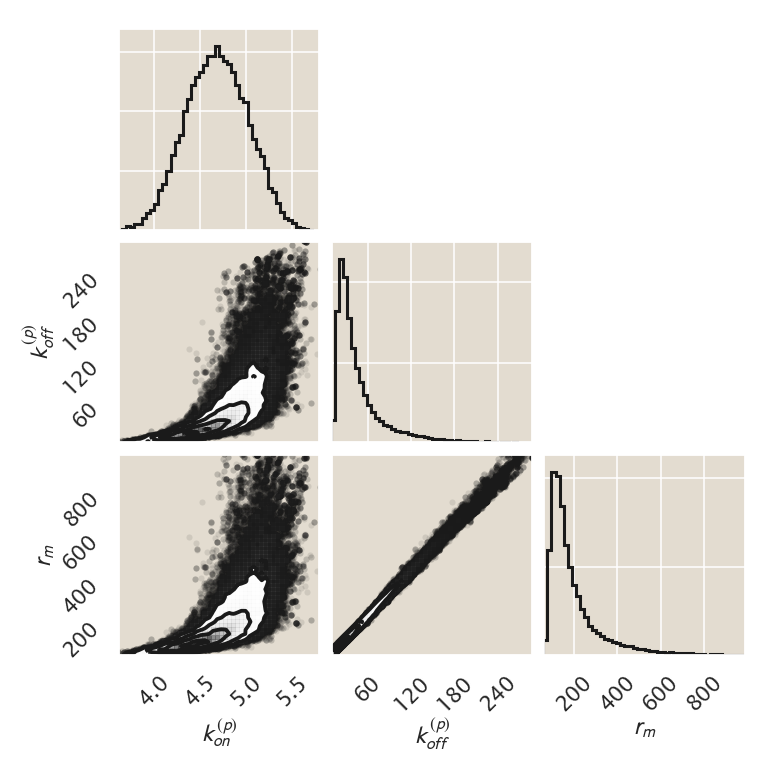

In [10]:
# Load the flat-chain
with open('../../data/mcmc/lacUV5_constitutive_mRNA_prior.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()

# Initialize subplot
fig, axes = plt.subplots(3, 3, figsize=(3.5, 3.5))


# Draw the corner plot
fig = corner.corner(gauss_flatchain, bins=50, plot_contours=True,
              labels=[r'$k^{(p)}_{on}$', r'$k^{(p)}_{off}$', r'$r_m$'],
              fig=fig)

# Save figure
plt.savefig(figdir + 'lacUV5_mRNA_prior_corner_plot.pdf', bbox_inches='tight')

For convenience let's conver the chain into a `pandas` DataFrame.

In [11]:
# Load the flat-chain
with open('../../data/mcmc/lacUV5_constitutive_mRNA_prior.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()
    
# Generate a Pandas Data Frame with the mcmc chain
index = ['kp_on', 'kp_off', 'rm']

# Generate a data frame out of the MCMC chains
df_mcmc = pd.DataFrame(gauss_flatchain, columns=index)

# rerbsine the index with the new entries
index = df_mcmc.columns
df_mcmc.head()

,kp_on,kp_off,rm
0,4.500354,26.064611,127.033465
1,4.500354,26.064611,127.033465
2,4.503202,24.794067,122.062939
3,4.500643,24.697176,121.701706
4,4.520637,24.964472,122.456293


Now we can find the most likely parameter and the hpd.

In [12]:
# map value of the parameters
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
kpon, kpoff, rm = df_mcmc.iloc[max_idx, :]

# ea range
kpon_hpd = ccutils.stats.hpd(df_mcmc.iloc[:, 0], 0.95)
kpoff_hpd = ccutils.stats.hpd(df_mcmc.iloc[:, 1], 0.95)
rm_hpd = ccutils.stats.hpd(df_mcmc.iloc[:, 2], 0.95)

# Print results
print("""
The most probable parameters for the model
------------------------------------------
kp_on = {0:.1f} -{1:0.1f} +{2:0.1f}
kp_off = {3:.1f} -{4:0.1f} +{5:0.1f}
rm = {6:.1f} -{7:0.1f} +{8:0.1f}
""".format(kpon, np.abs(kpon-kpon_hpd[0]), np.abs(kpon-kpon_hpd[1]),\
           kpoff, np.abs(kpoff-kpoff_hpd[0]), np.abs(kpoff-kpoff_hpd[1]),\
           rm, np.abs(rm-rm_hpd[0]), np.abs(rm-rm_hpd[1])))


The most probable parameters for the model
------------------------------------------
kp_on = 4.3 -0.3 +1.0
kp_off = 19.8 -10.1 +120.0
rm = 103.8 -37.4 +423.2



Let's convert these parameters to seconds using the value for the mRNA degradation rate $\gm$

In [13]:
# Define mRNA rate
gm = 1 / (3 * 60)  # s**-1

# Print results
print("""
The most probable parameters for the model in seconds^-1
--------------------------------------------------------
kp_on = {0:.3f} -{1:0.3f} +{2:0.3f} s^-1
kp_off = {3:.3f} -{4:0.3f} +{5:0.3f} s^-1
rm = {6:.3f} -{7:0.3f} +{8:0.3f} s^-1
""".format(kpon * gm, np.abs(kpon-kpon_hpd[0]) * gm, 
           np.abs(kpon-kpon_hpd[1]) * gm,
           kpoff * gm, np.abs(kpoff-kpoff_hpd[0]) * gm, 
           np.abs(kpoff-kpoff_hpd[1]) * gm,
           rm * gm, np.abs(rm-rm_hpd[0]) * gm, np.abs(rm-rm_hpd[1]) * gm))


The most probable parameters for the model in seconds^-1
--------------------------------------------------------
kp_on = 0.024 -0.002 +0.005 s^-1
kp_off = 0.110 -0.056 +0.667 s^-1
rm = 0.577 -0.208 +2.351 s^-1



Let's compare the theoretical prediction with the experimental data!

/Users/razo/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))


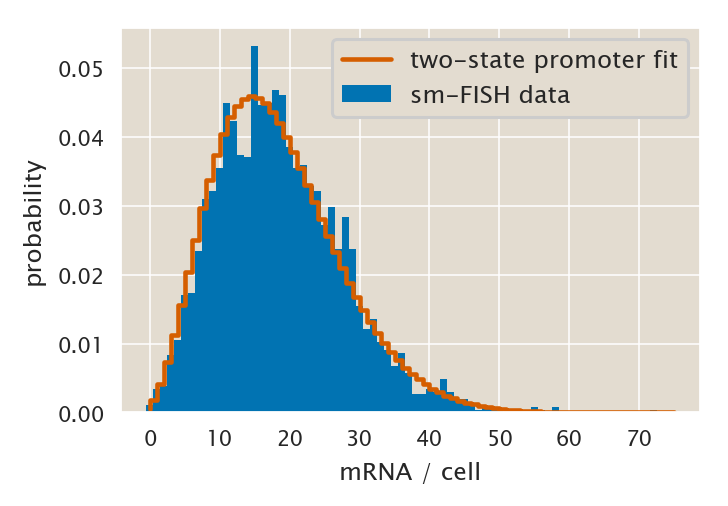

In [14]:
# Define bins
bins = np.arange(0, dfUV5.mRNA_cell.max())

logp_mRNA = log_p_m_unreg(bins, kpon, kpoff, 1, rm)

# Plot the histogram of the data with bins of width 1
_ = plt.hist(dfUV5.mRNA_cell, bins=bins, density=1, histtype='stepfilled',
             alpha=1, label='sm-FISH data', align='left', lw=0)

plt.step(bins, np.exp(logp_mRNA), color='r', ls='-', lw=1.5,
         label='two-state promoter fit')

# Label the plot
plt.xlabel('mRNA / cell')
plt.ylabel('probability')
plt.legend()
plt.tight_layout()
plt.savefig(figdir + 'lacUV5_two_state_mcmc_fit.pdf', bbox_inches='tight')

Let's now look at the CDF.

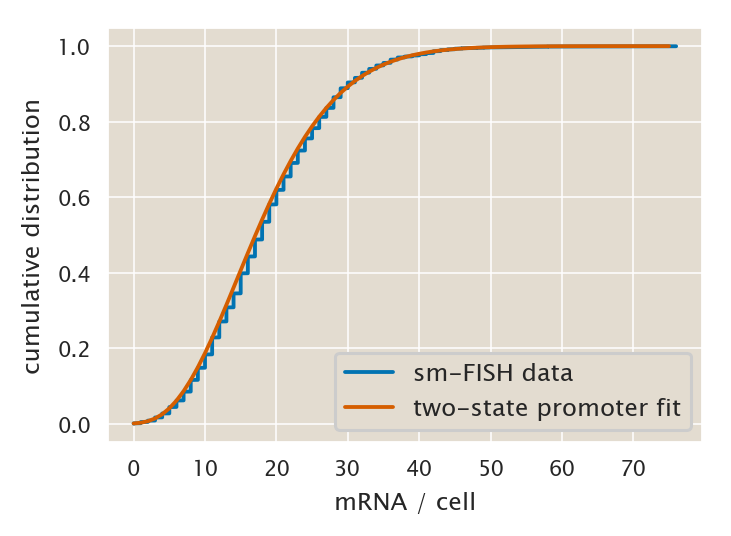

In [15]:
# Compute the empirical CDF
x, y = ccutils.stats.ecdf(dfUV5.mRNA_cell.values)
# Compute the theoretical CDF
cdf = np.cumsum(np.exp(logp_mRNA))

plt.plot(x, y, label='sm-FISH data')
plt.plot(bins, cdf, color='r', ls='-', label='two-state promoter fit')

plt.xlabel('mRNA / cell')
plt.ylabel('cumulative distribution')
plt.legend()
plt.savefig(figdir + 'lacUV5_two_state_CDF_mcmc_fit.pdf')

The agreement between theory and data seems to be very promising!
That means that the parameters inferred could be potentially meaningful.

## Accounting for variability in number of promoters and distribution of cells along the cell cycle.

Jones et al. claim that the contribution to the noise in gene expression can be partially explained by the variability in gene copy number. For the locus in which our reporter construct is located (*galK*) and the growth rate at which cells grew for this data we expect to have ≈ 1.66 copies of the gene. This implies that the cells spend **2/3** of the cell cycle with **two copies** of the promoter and the rest with a single copy.

Since for this data there is no labeling of the locus Jones et al. used area as a proxy for stage in the cell cycle. Therefore they took the bottom 1/3 of the cells as the population with a single copy of the promoter, and the top 2/3 of the cells as the cells having two copies. The assumption of having cells uniformly distributed along the cell cycle is not entirely correct. As first derived by [Powell in 1956](http://mic.microbiologyresearch.org/content/journal/micro/10.1099/00221287-15-3-492) a log-phase culture of cells must be exponentially distributed along the cell cycle in order to have ensemble averages to be stationary with respect to time. This distribution of cell-cycle state is then given by

$$
P(a) = (\ln 2) \cdot 2^{1 - a},
\tag{10}
$$
where $a \in [0, 1]$ is the stage of the cell cycle, with $a = 0$ being the start and $a = 1$ being the cell division.

Given this distribution if we again use the area as a proxy for cellular state taking the bottom 33% as cells with one promoter doesn't satisfy this distribution. To find a better threshold we must compute the CDF defined as

$$
CDF(x) \equiv P(a \leq x) = \int_0^x (\ln 2) \cdot 2^{1 - a}.
\tag{11}
$$

Solving this integral gives

$$
CDF(x) = 2 \left[1 - 2^{-x} \right].
\tag{12}
$$

Setting $x = 1/3$ we can obtain the fraction of cells to take as cells with a single promoter.

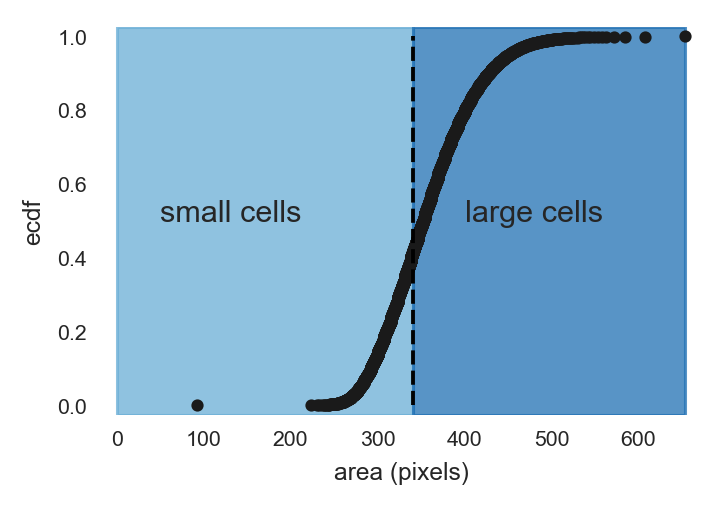

In [16]:
# Compute the area ECDF
x, y = ccutils.stats.ecdf(df['area_cells'])

# Find the value to separate small from large cells
frac = 1 / 3
fraction = 2 * (1 - 2**(-frac))
idx = (np.abs(y - fraction)).argmin()
threshold = x[idx]

# Define colors for each group of cells
colors = sns.color_palette('Blues', n_colors=3)[1::]

with sns.axes_style('white', {'axes.spines.bottom': False,
                              'axes.spines.left': False,
                              'axes.spines.right': False,
                              'axes.spines.top': False,}):
    # Plot this ECDF
    plt.plot(x[::20], y[::20], lw=0, marker='.', color='k')
    # Plot vertical line next to the threshold
    plt.plot([threshold, threshold], [0, 1], color='black', linestyle='--')

    # Fill the area for small and large cells
    plt.axvspan(0, threshold, alpha=0.75, color=colors[0])
    plt.axvspan(threshold, max(x[::20]), alpha=0.75, color=colors[1])

    # Label as small and large cells
    plt.text(50, 0.5, 'small cells', fontsize=10)
    plt.text(400, 0.5, 'large cells', fontsize=10)

    # Label plot
    plt.xlabel('area (pixels)')
    plt.ylabel('ecdf')
    plt.margins(0.025)

# Save figure
plt.tight_layout()
plt.savefig(figdir + 'area_division_expo.pdf', bbox_inches='tight')

Let's now extend the tidy dataframe to include the size information. Just as Jones et al. we will remove from the dataset for the inference cells that are 10% above and below the threshold for a "cleaner" cutoff.

In [17]:
# Initialize array to save size classification
size = np.empty(len(dfUV5), dtype=str)

# Define threshold for small cells
frac = (1 / 3) - (1 / 10)
fraction = 2 * (1 - 2**(-frac))
idx = (np.abs(y - fraction)).argmin()
threshold = x[idx]
# Determine which cells are considered small
size[dfUV5.area_cells < threshold] = 's'

# Define threshold for large cells
frac = (1 / 3) + (1 / 10)
fraction = 2 * (1 - 2**(-frac))
idx = (np.abs(y - fraction)).argmin()
threshold = x[idx]
# Determine which cells are considered large
size[dfUV5.area_cells >= threshold] = 'l'

# Save information on data frame
dfUV5 = dfUV5.assign(size = size)

# Remove unassigned cells
dfUV5 = dfUV5[dfUV5['size'] != '']

dfUV5.head()

,area_cells,date,experiment,mRNA_cell,num_intens_totals,spots_totals,size
0,402,20111220,UV5,27,4.544086,21,l
1,288,20111220,UV5,19,3.196886,14,s
2,358,20111220,UV5,25,4.249250,19,l
3,310,20111220,UV5,30,5.075867,22,s
4,300,20111220,UV5,31,5.361156,24,s


Having split cells by area let's look at the distributions of these two populations next to each other.

No handles with labels found to put in legend.


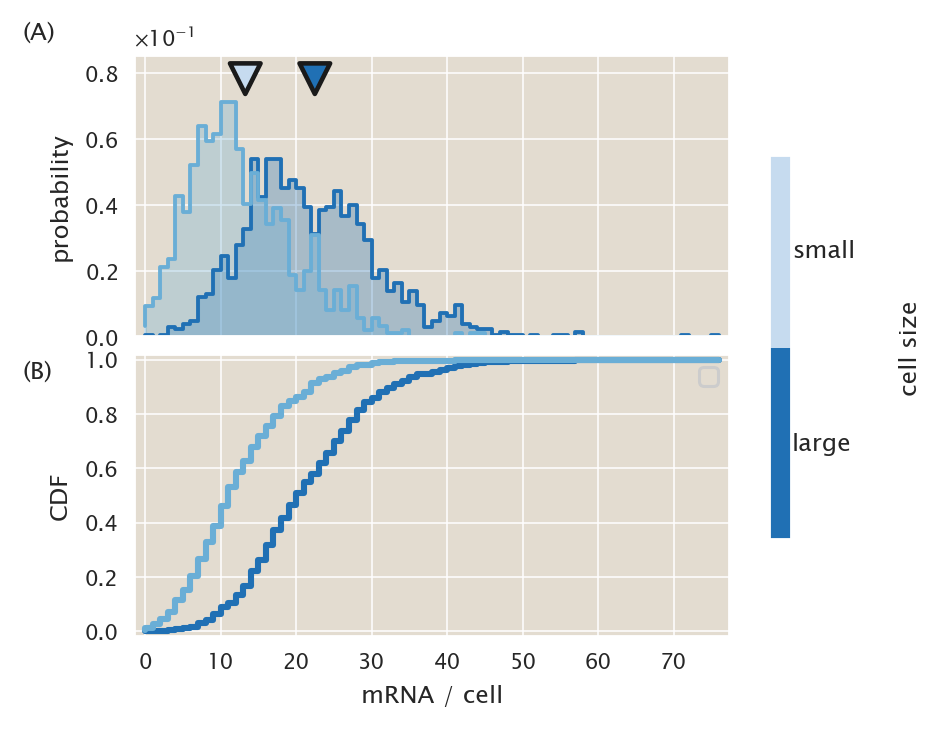

In [18]:
# Group them by size
df_group = dfUV5.groupby('size')

# Define labels for cell size
exps = ['large', 'small']

# indicate bins
x = np.arange(dfUV5['mRNA_cell'].max() + 1)

# Initialize array to save distributions
px = np.zeros([len(exps), len(x)])

# Loop through each group and save probability
for i, (group, data) in enumerate(df_group):
    prob = data.mRNA_cell.value_counts(normalize=True, sort=False) 
    px[i, prob.index] = prob.values

# Define colors
cmap =  sns.color_palette('Blues', n_colors=3)[::-1]

ccutils.viz.pmf_cdf_plot(x, px, exps, xlabel='mRNA / cell',
                         marker_size=100,
                         color_palette=cmap, pmf_alpha=0.3,
                         pmf_edgecolor=cmap,
                         ylim=[0, np.max(px) * 1.2], 
                         cbar_label='cell size')

plt.savefig(figdir + 'lacUV5_mRNA_size_PMF_CDF_expo.pdf', bbox_inches='tight')

The distributions are definitely different. Let's look at the summary statistics for these two groups.

In [19]:
dfUV5['mRNA_cell'].groupby(dfUV5['size']).describe()

,count,mean,std,min,25%,50%,75%,max
size,,,,,,,,
l,1219.0,22.478261,8.877018,1.0,16.0,21.0,28.0,76.0
s,842.0,13.262470,6.982311,0.0,8.0,12.0,17.0,45.0


### Defining the log posterior probability

Having split the cells into small and large cells we can again use Bayes theorem to fit the parameters. Just as before given that we want to infer three parameters, $\kpon$, $\kpoff$ and $\rm$ we can write Bayes theorem as

$$
P(\mathbf{p} \mid D) = {P(D \mid \mathbf{p}) P(\mathbf{p})
\over P(D)},
\tag{13}
$$
where $\mathbf{p} = (\kpon, \kpoff, \rm)$, and $D$ is the data. In this case we can split the data $D$ into two groups $D_1$ for cells with 1 copy of the promoter and $D_2$ for cells with two promoters. If we assume that each datum is independent we have for the likelihood $P(D \mid \mathbf{p})$ that

$$
P(D \mid \mathbf{p}) = \prod_{m \in D_1} P(m \mid \mathbf{p_1}) \cdot
\prod_{m \in D_2} P(m \mid \mathbf{p_2}),
\tag{14}
$$
where $\mathbf{p_1} = (\kpon, \kpoff, \rm)$ are the parameters for the single copy cell and $\mathbf{p_2} = (\kpon, \kpoff, 2\rm)$ are the parametres for cells with two copies. We obviously assume that the only difference between the single and double promoter cells is that the production rate duplicates for cells with two promoters.

As for the prior we have that the mean mRNA $\ee{m}$ for this multi-promoter model is given by

$$
\ee{m} = \phi \ee{m}_1 + (1 - \phi) \ee{m}_2,
\tag{15}
$$
wherea $\phi$ is the probability of sampling a cell with one promoter, and $\ee{m}_i$, $i \in \{1, 2 \}$ is the mean copy number of mRNA expected at steady state with $i$ promoters. The probability $\phi$ is given by

$$
\phi = \int_0^f P(a)da.
\tag{16}
$$

Substituting these mean values with the theoretical expectation we obtain

$$
\ee{m} = \phi {r_m \over \gm} {\kpon \over \kpon + \kpoff} +
         (1 - \phi) {2r_m \over \gm} {\kpon \over \kpon + \kpoff}.
\tag{17}
$$
This can further be simplified to

$$
\ee{m} = (2 - \phi) {r_m \over \gm} {{\kpon \over \kpoff} \over 1 + {\kpon \over \kpoff}}.
\tag{18}
$$

When compared with the thermodynamic equivalent mean mRNA we find that

$$
(2 - \phi) {r_m \over \gm} {{\kpon \over \kpoff} \over 1 + {\kpon \over \kpoff}} =
{r_m \over \gm}{{P \over N_{NS}} e^{-\beta\Delta\varepsilon_p} \over
1 + {P \over N_{NS}} e^{-\beta\Delta\varepsilon_p}}.
\tag{19}
$$

Solving for ${\kpon \over \kpoff}$ results in

$$
\left[ \left(1 + {P \over N_{NS}} e^{-\beta\Delta\varepsilon_p}\right) (2 - \phi) \right]
{\kpon \over \kpoff} = {P \over N_{NS}} e^{-\beta\Delta\varepsilon_p}.
\tag{20}
$$
Using the so-called weak promoter approximation where ${P \over N_{NS}} e^{-\beta\Delta\varepsilon_p}\ll 1$, justified by the numerical values of these variables we arrive to a form for the prior of the form

$$
{\kpon \over \kpoff} \approx {1 \over 2 - \phi}{P \over N_{NS}} e^{-\beta\Delta\varepsilon_p},
\tag{21}
$$
or in log scale

$$
\ln \left({\kpon \over \kpoff}\right) \approx -\ln(2 - \phi) - \beta\Delta\varepsilon_p + \ln P -\ln N_{NS}.
\tag{22}
$$

In [20]:
def log_likelihood_double(params, data):
    """
    Log likelihood for the mRNA two-state distribution.
    Parameters
    ----------
    params : array-like. 3 x 1.
        kp_on, kp_off, rm parameters for the steady state mRNA distribution
    data : 
        data[0] : array-like. n x 2
        data[0][:, 0] = unique mRNA counts for small cells
        data[0][:, 1] = frequency of each mRNA count for small cells
        data[1] : array-like. n x 2
        data[1][:, 0] = unique mRNA counts for large cells
        data[1][:, 1] = frequency of each mRNA count for large cells
    
    NOTE: The likelihood asks for unique mRNA entries and their corresponding 
    counts to speed up the process of computing the probability distribution. 
    Instead of computing the probability of 3 mRNAs n times, it computes it 
    once and multiplies the value by n.
    """
    # Unpack parameters
    kp_on, kp_off, rm = params
    # Unpack data
    mRNA_small, counts_small = data[0][:, 0], data[0][:, 1]
    mRNA_large, counts_large = data[1][:, 0], data[1][:, 1]
    
    return np.sum(counts_small * log_p_m_unreg(mRNA_small, kp_on, kp_off, 1, rm))\
    + np.sum(counts_large * log_p_m_unreg(mRNA_large, kp_on, kp_off, 1, 2 * rm))

def log_prior_double(params, pmax, thermo):
    """
    Log prior for kinetic parameters.
    Parameters
    ----------
    params : array-like. 3 x 1.
        kp_on, kp_off, rm parameters for the steady state mRNA distribution
    pmax : array-like. 3 x 1.
        maximum value for the parameters given in the same order as params
    thermo : array-like. 2 x 1.
        thermo[0] = mean value for the thermodynamic constraint
        thermo[1] = variance for the thermodynamic constraint
        
    """
    # Unpack parameters
    kp_on, kp_off, rm = params
    kp_on_max, kp_off_max, rm_max = pmax
    
    # Define uniform priors for parameters
    if np.any(params < 1E-7):
        return -np.inf
    
    if kp_on > kp_on_max or kp_off > kp_off_max or rm > rm_max:
        return -np.inf

    return - (np.log(kp_on / kp_off) - thermo[0])**2 / 2 / thermo[1]**2


def log_posterior_double(params, data, pmax, thermo, log_sampling=False):
    """
    Log posterior
    """
    # Boolean logic to sample in linear or in log scale
    if log_sampling:
        params = 10**params
        
    # Compute log prior
    lp = log_prior_double(params, pmax, thermo)

    # If log prior is -inf, return that
    if lp == -np.inf:
        return -np.inf

    # Compute and return posterior
    return lp + log_likelihood_double(params, data)

Let's prepare the MCMC run to obtain the parameter values.

For our Gaussian prior we have two variable numbers in this equation. On the one hand the RNAP copy number is reported to be within 1000 and 3000 per cell. On the other hand the binding energy is reported to vary between -5 and -7 $k_BT$. We set the mean value for both variables ($P = 2000$, $\eP = -6 k_BT$) as the mean of the Gaussian prior and the difference between the lower bound of both values ($P = 1000$, $\eP = -5 k_BT$) and the upper bound ($P = 1000$, $\eP = -5 k_BT$) as the mean $\pm 2 \sigma$.

In [21]:
# Evaluate thermodynamic constraint

# Define lambda function to compute the constraint
constraint = lambda phi, P, eps: - np.log(2 - phi) - eps + np.log(P) - np.log(4.6E6)

# Compute the mean value of the constraint
frac = 1 / 3  # Fraction of the cell cycle with 1 promoter copy
phi = 2 * (1 - 2**(-frac))  # Probability of sampling a cell with a single promoter
thermo_mean = constraint(phi, 2000, -6)

# Compute the upper and lower bound of the constraint
thermo_low = (constraint(phi, 1000, -5) - thermo_mean) / 2
thermo_high = (constraint(phi, 3000, -7) - thermo_mean) / 2

# Print contraint
print('Thermodynamic constraint = {0:.2f} + {1:.2f} - {2:.2f}'.format(thermo_mean, thermo_low, thermo_high))

Thermodynamic constraint = -2.20 + -0.85 - 0.70


In [22]:
#Define the parameters for emcee
n_dim = 3 # number of parameters to fit

n_walkers = 30
n_burn = 500
n_steps = 5000

# Splot DataFrame by area
dfUV5_small = dfUV5[dfUV5['area_cells'] < threshold]
# generate counts of each of the mRNA values
counts = dfUV5_small.mRNA_cell.value_counts(sort=True)
# append it into a n x 2 numpy arrray
data_small = np.vstack([counts.index.values, counts.values]).T

# Splot DataFrame by area
dfUV5_large = dfUV5[dfUV5['area_cells'] > threshold]
# generate counts of each of the mRNA values
counts = dfUV5_large.mRNA_cell.value_counts(sort=True)
# append it into a n x 2 numpy arrray
data_large = np.vstack([counts.index.values, counts.values]).T

# Join data sets
data = (data_small, data_large)

# Define parameter maximum values
pmax = [20, 2500, 2500]

# Define thermodynamic constraint
thermo = [thermo_mean, np.mean(np.abs([thermo_low, thermo_high]))]

# Initialize walkers
p0 = np.zeros([n_walkers, n_dim])
# Initialize kpon
p0[:, 0] = np.random.uniform(1E-5, 10, n_walkers)
# Initialize kpoff close to the ratio
p0[:, 1] = p0[:, 0] / np.exp(thermo_mean)
# initialize rm
p0[:, 2] = np.random.uniform(10, 100, n_walkers)


# Call the sampler. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior_double,\
            args=(data, pmax, thermo),\
            threads=6)

Now we can run it!

In [23]:
sample = False
if sample:
    #Do the burn in 
    print('performing burn-in')
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
    # Perform the real MCMC
    print('performing MCMC')
    _ = sampler.run_mcmc(pos, n_steps)
    output = open('../../data/mcmc/' +
                  'lacUV5_constitutive_mRNA_double_expo.pkl', 'wb')
    print('done!')
    pickle.dump(sampler.flatchain, output)
    pickle.dump(sampler.flatlnprobability, output)
    output.close() # close it to make sure it's all been written

Having finished the sampling let's load the chains and plot the corner-plot.

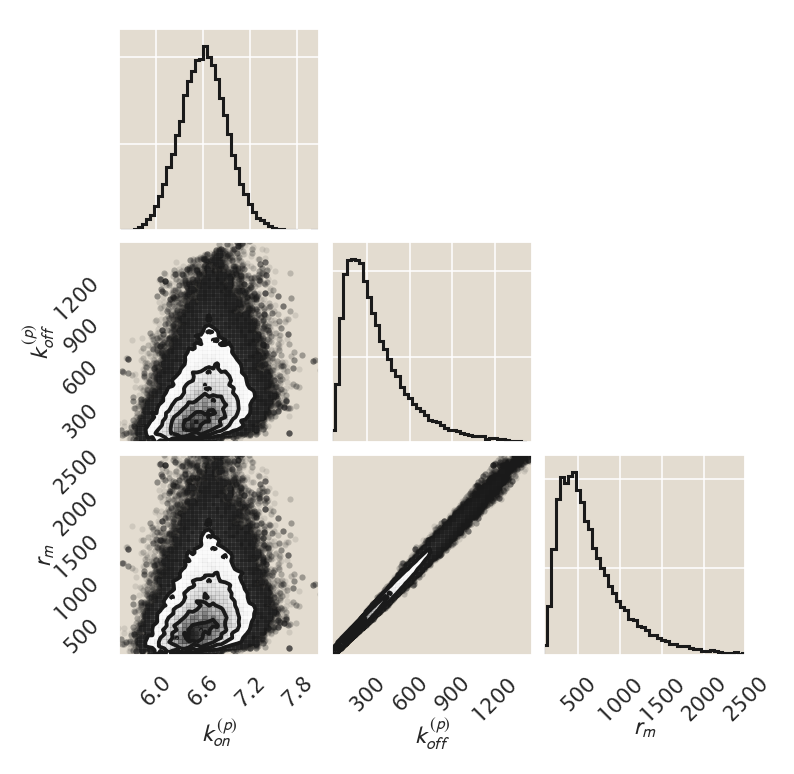

In [24]:
# Load the flat-chain
with open('../../data/mcmc/lacUV5_constitutive_mRNA_double_expo.pkl',
          'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()

# Initialize subplot
fig, axes = plt.subplots(3, 3, figsize=(3.5, 3.5))

# Draw the corner plot
fig = corner.corner(gauss_flatchain, bins=50, plot_contours=True,
              labels=[r'$k^{(p)}_{on}$', r'$k^{(p)}_{off}$', r'$r_m$'],
              fig=fig)

plt.savefig(figdir + 'lacUV5_mRNA_double_expo_corner_plot.pdf',
            bbox_inches='tight')

There is a single peak again. The model is still obviously degenerated, but given our priors we can get at a value of the parameters represented by the single peak of the most likely parameter value.
Let's transform the chain in to a DataFrame.

In [25]:
# Load the flat-chain
with open('../../data/mcmc/lacUV5_constitutive_mRNA_double_expo.pkl',
          'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()
    gauss_flatlnprobability = unpickler.load()
    
# Generate a Pandas Data Frame with the mcmc chain
index = ['kp_on', 'kp_off', 'rm']

# Generate a data frame out of the MCMC chains
df_mcmc = pd.DataFrame(gauss_flatchain, columns=index)

# rerbsine the index with the new entries
index = df_mcmc.columns
df_mcmc.head()

,kp_on,kp_off,rm
0,6.933279,303.854756,535.613114
1,6.933279,303.854756,535.613114
2,6.933279,303.854756,535.613114
3,6.933279,303.854756,535.613114
4,6.933279,303.854756,535.613114


Now let's find the most likely parameter along with the hpd.

In [26]:
# map value of the parameters
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
kpon_double, kpoff_double, rm_double = df_mcmc.iloc[max_idx, :]

# ea range
kpon_hpd = ccutils.stats.hpd(df_mcmc.iloc[:, 0], 0.95)
kpoff_hpd = ccutils.stats.hpd(df_mcmc.iloc[:, 1], 0.95)
rm_hpd = ccutils.stats.hpd(df_mcmc.iloc[:, 2], 0.95)

# Print results
print("""
The most probable parameters for the model
------------------------------------------
kp_on = {0:.1f} -{1:0.1f} +{2:0.1f}
kp_off = {3:.1f} -{4:0.1f} +{5:0.1f}
rm = {6:.1f} -{7:0.1f} +{8:0.1f}
""".format(kpon_double, np.abs(kpon_double-kpon_hpd[0]), 
           np.abs(kpon_double-kpon_hpd[1]),
           kpoff_double, np.abs(kpoff_double-kpoff_hpd[0]), 
           np.abs(kpoff_double-kpoff_hpd[1]),\
           rm_double, np.abs(rm_double-rm_hpd[0]), np.abs(rm_double-rm_hpd[1])))


The most probable parameters for the model
------------------------------------------
kp_on = 6.4 -0.4 +0.8
kp_off = 132.1 -75.2 +737.9
rm = 257.2 -132.3 +1307.7



Let's conver these rates to $s^{-1}$.

In [27]:
# Define mRNA rate
gm = 1 / (3 * 60)  # s**-1

# Print results
print("""
The most probable parameters for the model in seconds^-1
--------------------------------------------------------
kp_on = {0:.3f} -{1:0.3f} +{2:0.3f} s^-1
kp_off = {3:.3f} -{4:0.3f} +{5:0.3f} s^-1
rm = {6:.3f} -{7:0.3f} +{8:0.3f} s^-1
""".format(kpon_double * gm, np.abs(kpon_double-kpon_hpd[0]) * gm, 
           np.abs(kpon_double-kpon_hpd[1]) * gm,
           kpoff_double * gm, np.abs(kpoff_double-kpoff_hpd[0]) * gm, 
           np.abs(kpoff_double-kpoff_hpd[1]) * gm,
           rm_double * gm, np.abs(rm_double-rm_hpd[0]) * gm, np.abs(rm_double-rm_hpd[1]) * gm))


The most probable parameters for the model in seconds^-1
--------------------------------------------------------
kp_on = 0.036 -0.002 +0.004 s^-1
kp_off = 0.734 -0.418 +4.099 s^-1
rm = 1.429 -0.735 +7.265 s^-1



Let's plot the fit for this multi-promoter copy model.

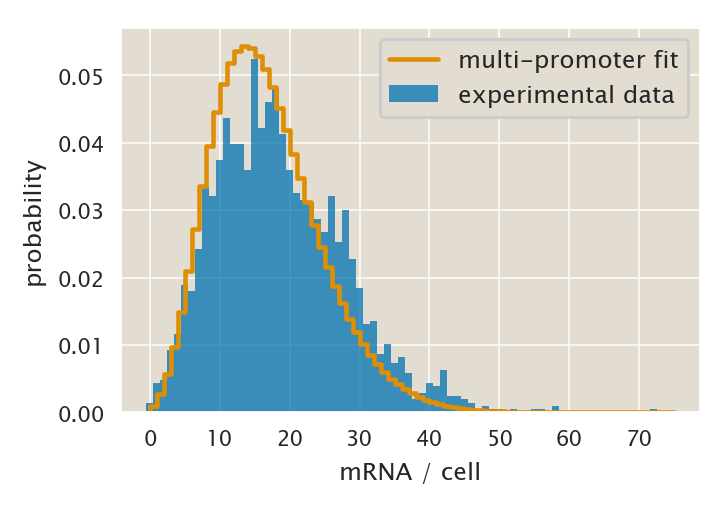

In [28]:
# Define bins
bins = np.arange(0, dfUV5.mRNA_cell.max())

# Compute the probability using a two-copy promoter
frac = 1 / 3
fraction = 2 * (1 - 2**(-frac))

logp_mRNA_double = fraction * log_p_m_unreg(bins, kpon_double, 
                                            kpoff_double, 1, rm_double)\
                +  (1 - fraction) * log_p_m_unreg(bins, kpon_double, kpoff_double, 
                                                  1, 2 * rm_double)
# Re-Normalize distribution
logp_mRNA_double = logp_mRNA_double - scipy.special.logsumexp(logp_mRNA_double)

# Plot the histogram of the data with bins of width 1
_ = plt.hist(dfUV5.mRNA_cell, bins=bins, density=1, histtype='stepfilled',
             alpha=.75, label='experimental data', align='left', lw=0)

plt.step(bins, np.exp(logp_mRNA_double), 
         lw=1.5,
         label='multi-promoter fit')

# Label the plot
plt.xlabel('mRNA / cell')
plt.ylabel('probability')
plt.legend()

plt.tight_layout()
plt.savefig(figdir + 'lacUV5_two_state_mcmc_multi_copy_expo.pdf',
            bbox_inches='tight')

Now let's plot the single and double promoter distributions separated with their corresponding predictions.

/Users/razo/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/razo/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))


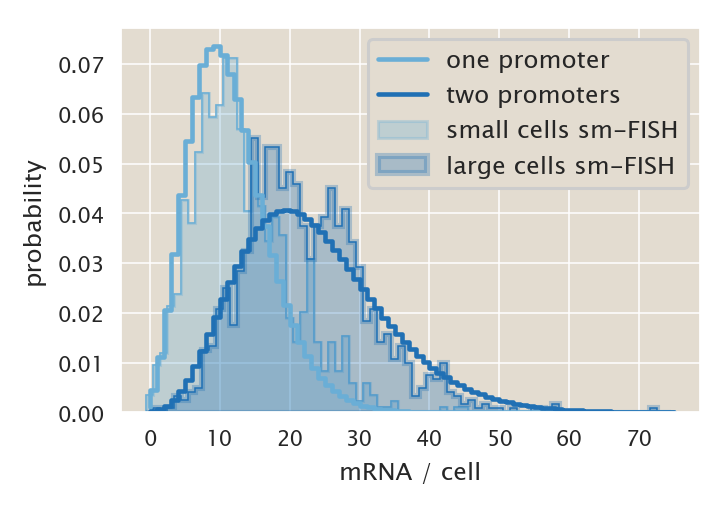

In [29]:
# Define colors for each group of cells
colors = sns.color_palette('Blues', n_colors=3)[1::]

# Define bins
bins = np.arange(0, dfUV5.mRNA_cell.max())

# Compute the probability
logp_mRNA_small = log_p_m_unreg(bins, kpon_double, kpoff_double, 1, rm_double)
logp_mRNA_large = log_p_m_unreg(bins, kpon_double, kpoff_double, 1, 2 * rm_double)

# Plot the histogram of the data with bins of width 1
plt.hist(dfUV5_small.mRNA_cell, bins=bins, density=1, histtype='stepfilled',
         alpha=.3, label='small cells sm-FISH', align='left', 
         color=colors[0], edgecolor=colors[0])
plt.hist(dfUV5_small.mRNA_cell, bins=bins, density=1, histtype='step',
         label='', align='left', lw=.5,
         edgecolor=colors[0])


plt.hist(dfUV5_large.mRNA_cell, bins=bins, density=1, histtype='stepfilled',
             alpha=.3, label='large cells sm-FISH', align='left',
             color=colors[1], edgecolor=colors[1], lw=2)
plt.hist(dfUV5_large.mRNA_cell, bins=bins, density=1, histtype='step',
         label='', align='left', lw=.5,
         edgecolor=colors[1])

# Plot theoretical predictions

plt.step(bins, np.exp(logp_mRNA_small), 
         color=colors[0], ls='-', lw=1.5,
         label='one promoter')
plt.step(bins, np.exp(logp_mRNA_large), 
         color=colors[1], ls='-', lw=1.5,
         label='two promoters')

# Label the plot
plt.xlabel('mRNA / cell')
plt.ylabel('probability')
_ = plt.legend()
plt.tight_layout()
plt.savefig(figdir + 'lacUV5_two_state_mcmc_multi_copy_expo_split.pdf',
            bbox_inches='tight')

Again very good fits for both populations. This suggests that the use of area as a proxy for cell state is not such a terrible approximation, and that the fact that large cells have a production rate of $2 r_m$ is also a good assumption.

Let's plot the single and split distribution on the same figure now

/Users/razo/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))
/Users/razo/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['ls', 'linestyle'] which are all aliases for 'linestyle'.  Kept value from 'linestyle'
  seen=seen, canon=canonical, used=seen[-1]))


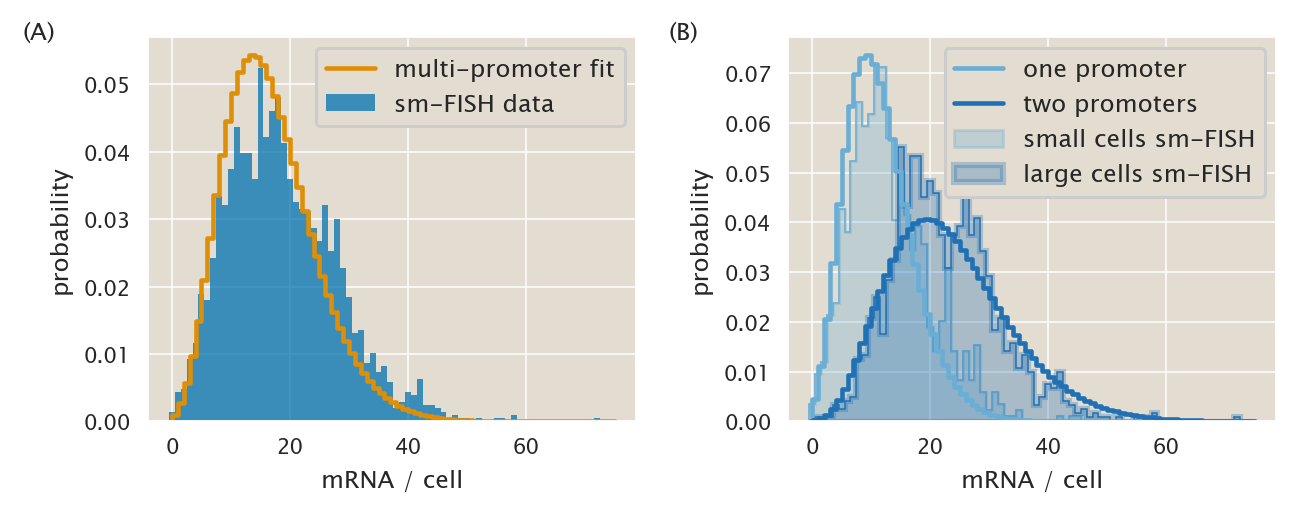

In [30]:
# Initialize figure
fig, ax = plt.subplots(1, 2, figsize=(6, 2.5), sharey=False, sharex=True)

##  Plot the single distribution  ##
# Define bins
bins = np.arange(0, dfUV5.mRNA_cell.max())

# Compute the probability using a two-copy promoter
frac = 1 / 3
fraction = 2 * (1 - 2**(-frac))

logp_mRNA_double = fraction * log_p_m_unreg(bins, kpon_double, 
                                            kpoff_double, 1, rm_double)\
                +  (1 - fraction) * log_p_m_unreg(bins, kpon_double, kpoff_double, 
                                                  1, 2 * rm_double)
# Re-Normalize distribution
logp_mRNA_double = logp_mRNA_double - scipy.special.logsumexp(logp_mRNA_double)

# Plot the histogram of the data with bins of width 1
_ = ax[0].hist(dfUV5.mRNA_cell, bins=bins, density=1, histtype='stepfilled',
             alpha=.75, label='sm-FISH data', align='left', lw=0)

ax[0].step(bins, np.exp(logp_mRNA_double), 
         lw=1.5,
         label='multi-promoter fit')

##  Plot split distributions  ##
# Define colors for each group of cells
colors = sns.color_palette('Blues', n_colors=3)[1::]

# Compute the probability
logp_mRNA_small = log_p_m_unreg(bins, kpon_double, kpoff_double, 1, rm_double)
logp_mRNA_large = log_p_m_unreg(bins, kpon_double, kpoff_double, 1, 2 * rm_double)

# Plot the histogram of the data with bins of width 1
ax[1].hist(dfUV5_small.mRNA_cell, bins=bins, density=1, histtype='stepfilled',
         alpha=.3, label='small cells sm-FISH', align='left', 
         color=colors[0], edgecolor=colors[0])
ax[1].hist(dfUV5_small.mRNA_cell, bins=bins, density=1, histtype='step',
         label='', align='left', lw=.5,
         edgecolor=colors[0])


ax[1].hist(dfUV5_large.mRNA_cell, bins=bins, density=1, histtype='stepfilled',
             alpha=.3, label='large cells sm-FISH', align='left',
             color=colors[1], edgecolor=colors[1], lw=2)
ax[1].hist(dfUV5_large.mRNA_cell, bins=bins, density=1, histtype='step',
         label='', align='left', lw=.5,
         edgecolor=colors[1])

# Plot theoretical predictions

ax[1].step(bins, np.exp(logp_mRNA_small), 
         color=colors[0], ls='-', lw=1.5,
         label='one promoter')
ax[1].step(bins, np.exp(logp_mRNA_large), 
         color=colors[1], ls='-', lw=1.5,
         label='two promoters')

# Label the plots
ax[0].set_xlabel('mRNA / cell')
ax[1].set_xlabel('mRNA / cell')

ax[0].set_ylabel('probability')
ax[1].set_ylabel('probability')

# Set legend
ax[0].legend()
ax[1].legend()

# Add labels to plots
plt.figtext(0.01, 0.9, '(A)', fontsize=8)
plt.figtext(0.5, 0.9, '(B)', fontsize=8)

# Save figure
plt.tight_layout()
plt.savefig(figdir + 'lacUV5_multi_prom_fit.pdf', bbox_inches='tight')